In [39]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
import pdb
from nilearn import image, datasets,plotting
import nibabel as nib
from scipy.stats import binom_test


In [104]:
'''exp info'''
subs = list(range(1001,1013))

#check 1001

#subs = list(range(1012,1005, -1))
#subs = list(range(1001,1006))
print(subs)
study ='spaceloc'
study_dir = f"/lab_data/behrmannlab/vlad/{study}"
out_dir = f'{study_dir}/derivatives/conjunction'
results_dir = '/user_data/vayzenbe/GitHub_Repos/docnet/results'
exp = 'spaceloc'
rois = ['PPC_spaceloc', 'APC_spaceloc', 'PPC_depthloc', 'APC_depthloc', 'PPC_toolloc', 'APC_toolloc', 'PPC_distloc', 'APC_distloc']
control_tasks = ['distloc','toolloc','depthloc']
parcel_roi = ['rPPC', 'rAPC']
whole_brain_mask = datasets.load_mni152_brain_mask()
affine = whole_brain_mask.affine

[1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012]


In [49]:
"""
analyze it as a proportion of the group ROI and then test using binomial
e.g., for each map calc proportion of spatial ROI in pIPS that overlaps with others
compare with 50% 
"""

clust_index = [2,1] #index corresponding to rPPC and rAPC, respectively


deriv_dir = f'{study_dir}/derivatives/fsl'
roi_dir = f'{study_dir}/derivatives/rois'


for pr in enumerate(parcel_roi):
    parcel = image.get_data(image.load_img(f'{roi_dir}/parcels/{pr[1]}.nii.gz'))
    parcel[parcel[:,:, :] >0] = 1

    space_clust = image.get_data(image.load_img(f'{deriv_dir}/HighLevel_spaceloc.gfeat/cope1.feat/cluster_mask_zstat1.nii.gz'))
    space_clust[space_clust[:,:, :] !=clust_index[pr[0]]] = 0
    space_clust[space_clust[:,:, :] >0] = 1
    space_clust = space_clust * parcel #extract only mask in parcel

    for ct in control_tasks:        

        control_clust = image.get_data(image.load_img(f'{deriv_dir}/HighLevel_{ct}.gfeat/cope1.feat/cluster_mask_zstat1.nii.gz'))
        control_clust[control_clust[:,:, :] >0] = 1
        control_clust = control_clust * space_clust #multiply by space clust to leave only overlapping voxels

        #add them together
        conj = space_clust + control_clust
        #set anything that isn't a conjunction to 0 and the conjunction to 1

        space_count = np.count_nonzero(conj == 1)
        conj_count  = np.count_nonzero(conj == 2)
        prop = space_count/(space_count +conj_count)
        print(pr, ct, prop, binom_test(space_count, n=(space_count+conj_count), p=0.5))

(0, 'rPPC') distloc 0.5801526717557252 0.0002802099819164453
(0, 'rPPC') toolloc 1.0 3.641767935156849e-158
(0, 'rPPC') depthloc 1.0 3.641767935156849e-158
(1, 'rAPC') distloc 0.3505402160864346 4.8267628447127754e-18
(1, 'rAPC') toolloc 0.5690276110444178 7.631888221796613e-05
(1, 'rAPC') depthloc 1.0 3.491753744649344e-251


In [100]:
"""
Create continuous conjunction figure
grab all voxels that are significant in at least one contrast
normalize them so you get relative activation to one condition vs. another 
(e.g., if highest z in tool is 5, but 4 in space tool might swamp space)
"""
parcel = np.zeros(whole_brain_mask.shape)
for lr in ['l','r']:
    for pr in parcel_roi:
        parcel = parcel + image.get_data(image.load_img(f'{roi_dir}/parcels/{lr}{pr}.nii.gz'))
#parcel = image.get_data(image.load_img(f'{roi_dir}/parcels/rPPC.nii.gz'))
parcel[parcel[:,:, :] >0] = 1

ct = 'distloc'
#load mask from spaceloc and control task
space_clust = image.get_data(image.load_img(f'{deriv_dir}/HighLevel_spaceloc.gfeat/cope1.feat/cluster_mask_zstat1.nii.gz'))
space_clust[space_clust[:,:, :] >0] = 1
control_clust = image.get_data(image.load_img(f'{deriv_dir}/HighLevel_{ct}.gfeat/cope1.feat/cluster_mask_zstat1.nii.gz'))
control_clust[control_clust[:,:, :] >0] = 1

#create combined mask that includes voxels that are significant in at least one condition
combined_mask = (space_clust + control_clust) * parcel
combined_mask[combined_mask[:,:, :] >0] = 1


#load stat image and keep voxles in the combined mask
space_stat = image.get_data(image.load_img(f'{deriv_dir}/HighLevel_spaceloc.gfeat/cope1.feat/stats/tstat1.nii.gz'))
space_stat = space_stat * combined_mask
control_stat = image.get_data(image.load_img(f'{deriv_dir}/HighLevel_{ct}.gfeat/cope1.feat/stats/tstat1.nii.gz'))
control_stat = control_stat * combined_mask

space_stat_norm = np.zeros(whole_brain_mask.shape)
control_stat_norm= np.zeros(whole_brain_mask.shape)
ratio_map= np.zeros(whole_brain_mask.shape)

#normalize voxels in each mask
#space_stat_norm[combined_mask[:,:, :] >0] = ((space_stat[combined_mask[:,:, :] >0] - np.mean(space_stat[combined_mask[:,:, :] >0]))/ np.std(space_stat[combined_mask[:,:, :] >0])) + 10
#control_stat_norm[combined_mask[:,:, :] >0] = ((control_stat[combined_mask[:,:, :] >0] - np.mean(control_stat[combined_mask[:,:, :] >0]))/ np.std(control_stat[combined_mask[:,:, :] >0])) + 10

space_stat_norm[combined_mask[:,:, :] >0] = (space_stat[combined_mask[:,:, :] >0] -space_stat[combined_mask[:,:, :] >0].min())/ (space_stat[combined_mask[:,:, :] >0].max() - space_stat[combined_mask[:,:, :] >0].min())
control_stat_norm[combined_mask[:,:, :] >0] = (control_stat[combined_mask[:,:, :] >0] -control_stat[combined_mask[:,:, :] >0].min())/ (control_stat[combined_mask[:,:, :] >0].max() - control_stat[combined_mask[:,:, :] >0].min())


ratio_map[combined_mask[:,:, :] >0] = space_stat_norm[combined_mask[:,:, :] >0] / (space_stat_norm[combined_mask[:,:, :] >0] + control_stat_norm[combined_mask[:,:, :] >0])



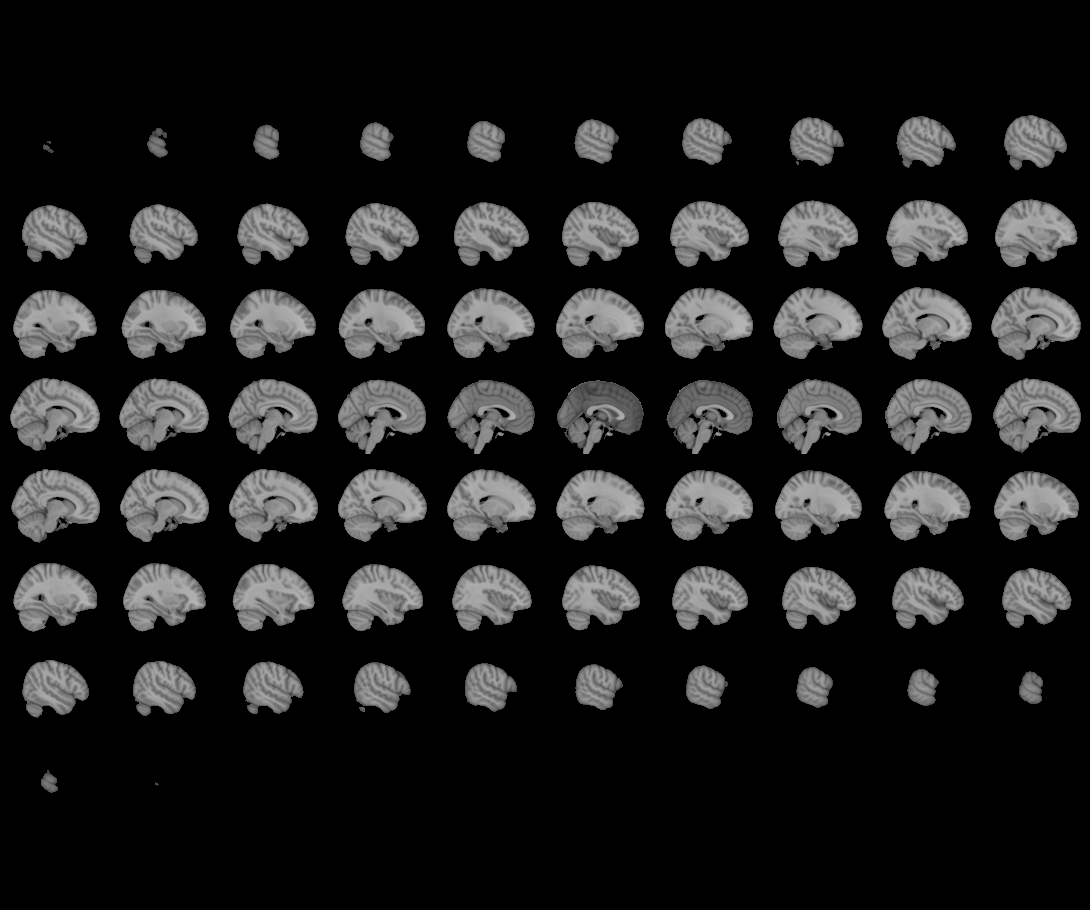
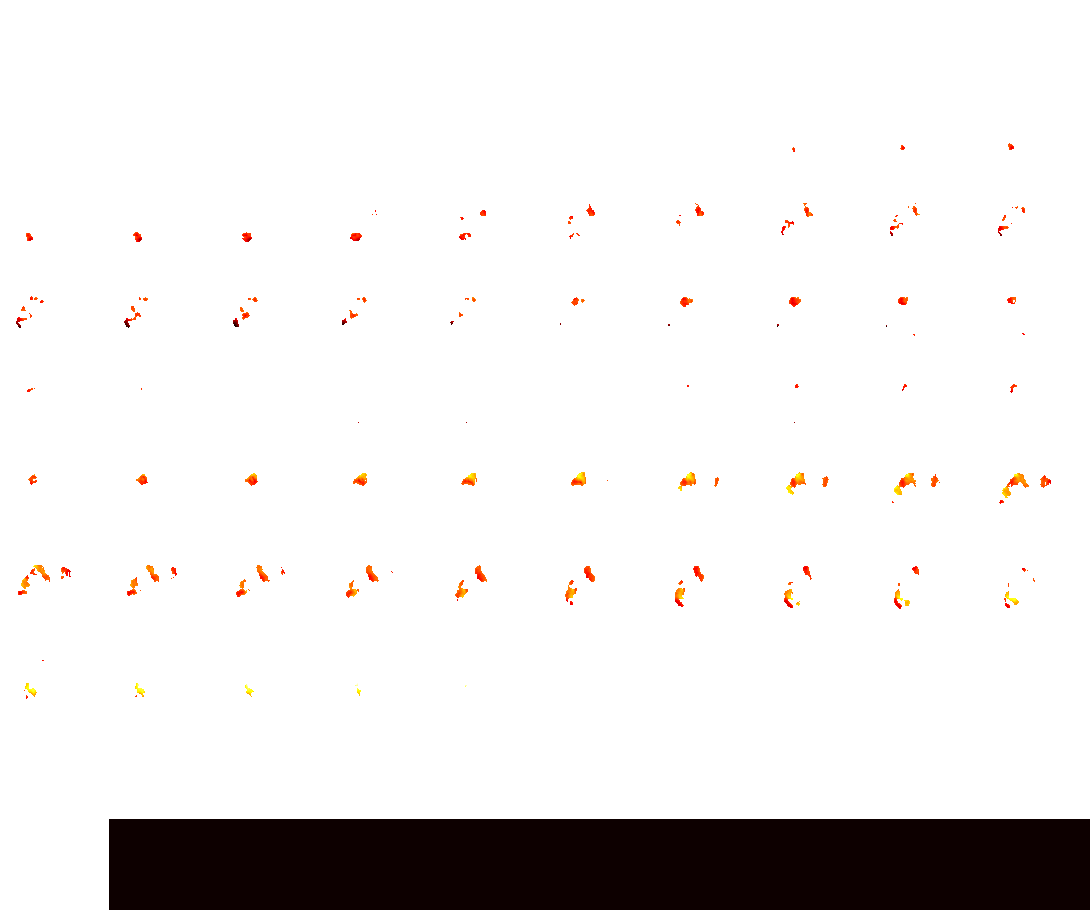

In [101]:
test = nib.Nifti1Image(ratio_map, affine)  # create the volume image
plotting.view_img(test)


In [103]:
nib.save(test, 'test.nii.gz')


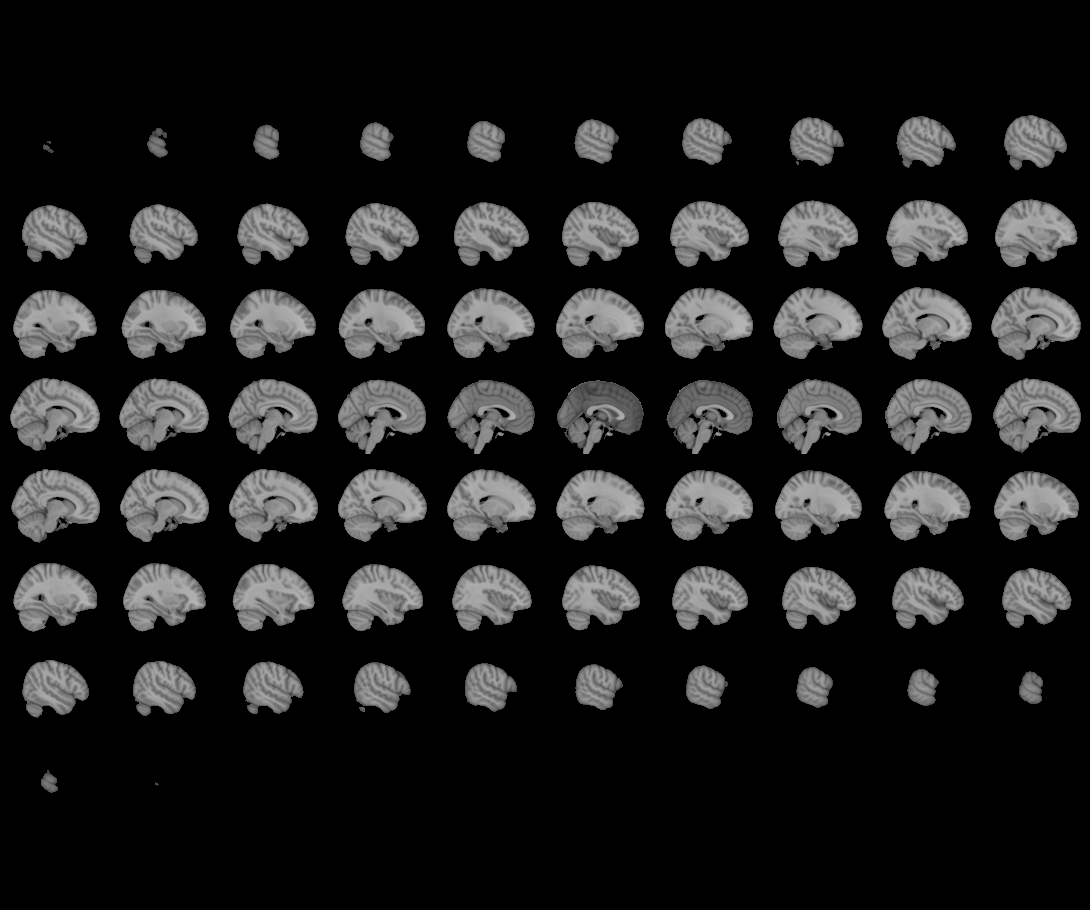
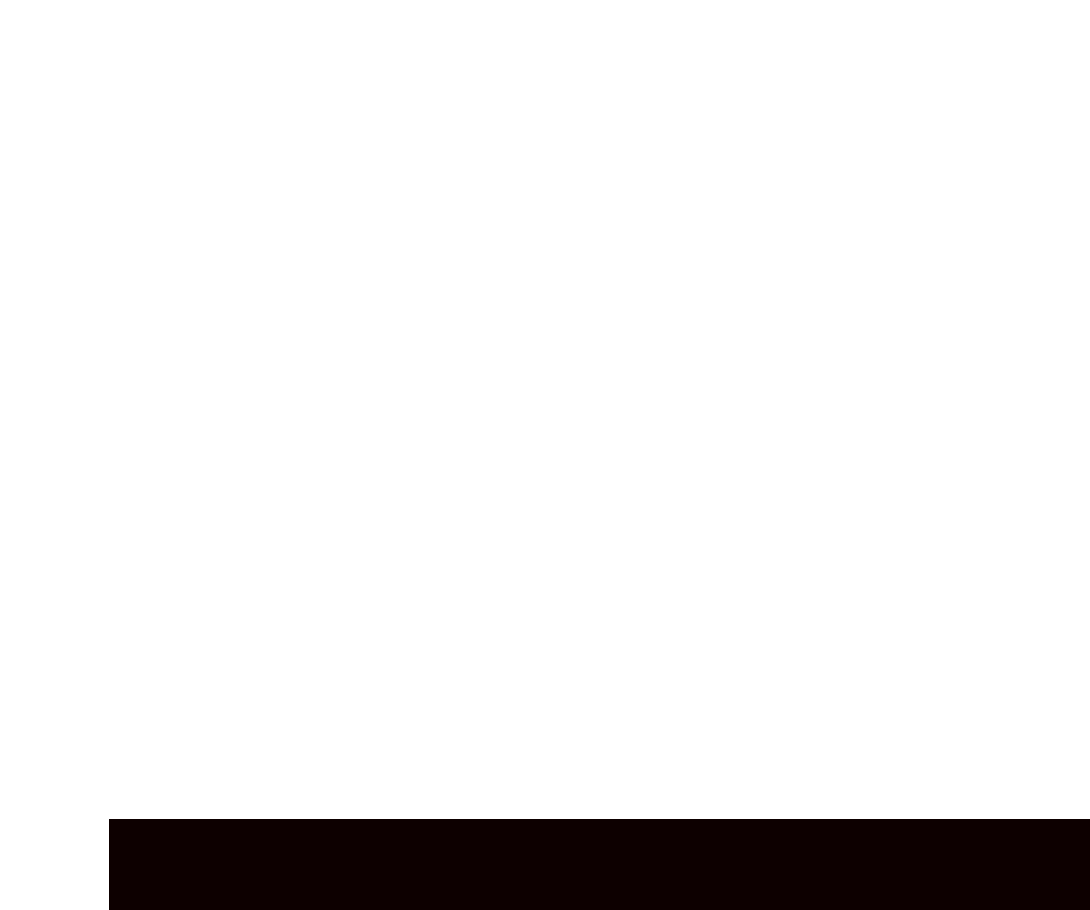

In [82]:
plotting.view_img(whole_brain_mask)

In [61]:
#analyze it as a proportion and then test using one-sample t
#e.g., for each sub calc proportion of spatial ROI in pIPS that overlaps with others
#compare wiht 50% 
ss = 1002
ct ='distloc'
parcel_roi = 'rAPC'


for ss in subs:
    sub_dir = f'{study_dir}/sub-{study}{ss}/ses-01/derivatives/fsl'
    roi_dir = f'{study_dir}/sub-{study}{ss}/ses-01/derivatives/rois'

    parcel = image.get_data(image.load_img(f'{roi_dir}/parcels/rPPC.nii.gz'))
    parcel[parcel[:,:, :] >0] = 1
    #load spaceloc zstatclust
    space_clust = image.get_data(image.load_img(f'{sub_dir}/spaceloc/HighLevel_roi_2runs.gfeat/cope1.feat/cluster_mask_zstat1.nii.gz'))
    space_clust[space_clust[:,:, :] >0] = 1
    space_clust = space_clust * parcel #extract only mask in parcel

    #load cluster map for control task
    control_clust = image.get_data(image.load_img(f'{sub_dir}/{ct}/HighLevel_roi.gfeat/cope1.feat/cluster_mask_zstat1.nii.gz'))
    control_clust[control_clust[:,:, :] >0] = 1
    control_clust = control_clust * space_clust #multiply by space clust to leave only overlapping voxels

    #add them together
    conj = space_clust + control_clust
    #set anything that isn't a conjunction to 0 and the conjunction to 1

    space_count = np.count_nonzero(conj == 1)
    conj_count  = np.count_nonzero(conj == 2)

    try:
        print(ss, space_count, conj_count, space_count/(space_count +conj_count))
    except:
        continue


1002 463 597 0.4367924528301887
1003 1087 755 0.5901194353963084
1004 26 348 0.06951871657754011
1005 309 132 0.7006802721088435
1006 81 10 0.8901098901098901
1007 43 342 0.11168831168831168
1008 18 40 0.3103448275862069
1009 1139 171 0.8694656488549618
1010 301 636 0.32123799359658484
1011 245 1090 0.18352059925093633
1012 92 171 0.34980988593155893


463 597 0.4367924528301887



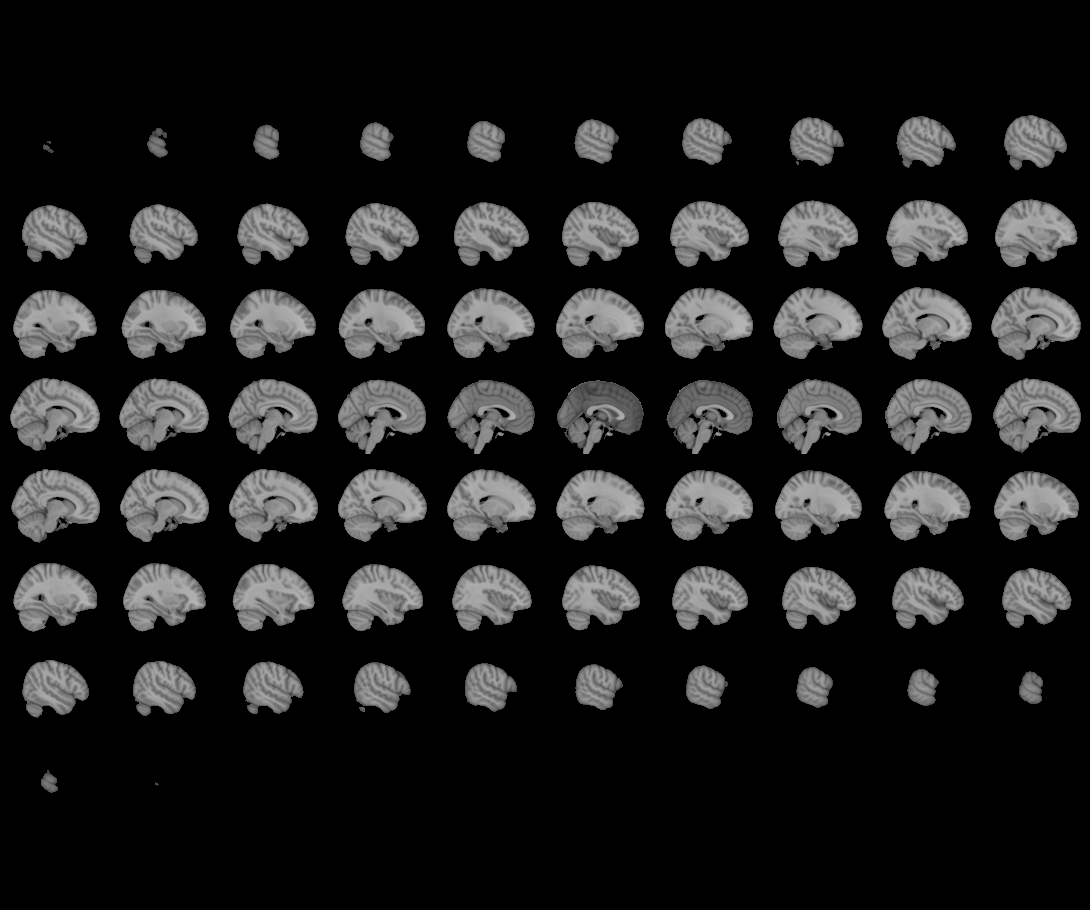
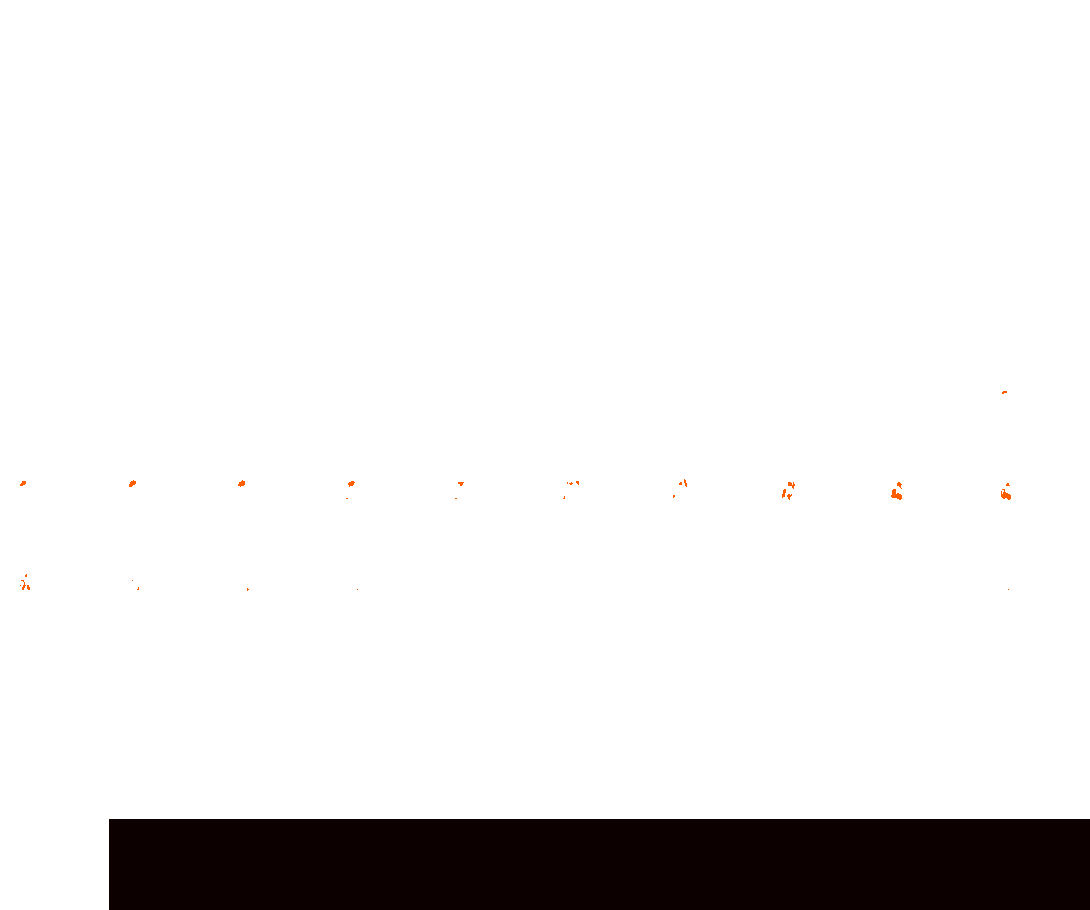

In [53]:
test = nib.Nifti1Image(conj, affine)  # create the volume image
plotting.view_img(test)

In [ ]:
conj[conj[:,:,:] <2] =0 #non-conj voxels
conj[conj[:,:,:] >0] =1 #conj-voxels


In [19]:

#for ct in control_tasks:
ct ='distloc'
all_space =np.zeros(whole_brain_mask.shape) 
all_conj = np.zeros(whole_brain_mask.shape)
all_control = np.zeros(whole_brain_mask.shape)
for ss in subs:
    #set sub directory
    sub_dir = f'{study_dir}/sub-{study}{ss}/ses-01/derivatives/fsl'
    #load spaceloc zstatclust
    space_clust = image.get_data(image.load_img(f'{sub_dir}/spaceloc/HighLevel_roi_2runs.gfeat/cope1.feat/cluster_mask_zstat1.nii.gz'))
    space_clust[space_clust[:,:, :] >0] = 1

    #load cluster map for control task
    control_clust = image.get_data(image.load_img(f'{sub_dir}/{ct}/HighLevel_roi.gfeat/cope1.feat/cluster_mask_zstat1.nii.gz'))
    control_clust[control_clust[:,:, :] >0] = 1

    #add them together
    conj = space_clust + control_clust
    #set anything that isn't a conjunction to 0 and the conjunction to 1
    conj[conj[:,:,:] <2] =0 #non-conj voxels
    conj[conj[:,:,:] >0] =1 #conj-voxels

    #add to group map
    all_space = all_space + space_clust
    all_conj = all_conj+ conj
    all_control = all_control + control_clust



    #non parametric map where you have significant majority with space, overlap, and control
    #place control map down, then space map, then conjunction
    #add constant so that space is least, conjunction is mid, control is most






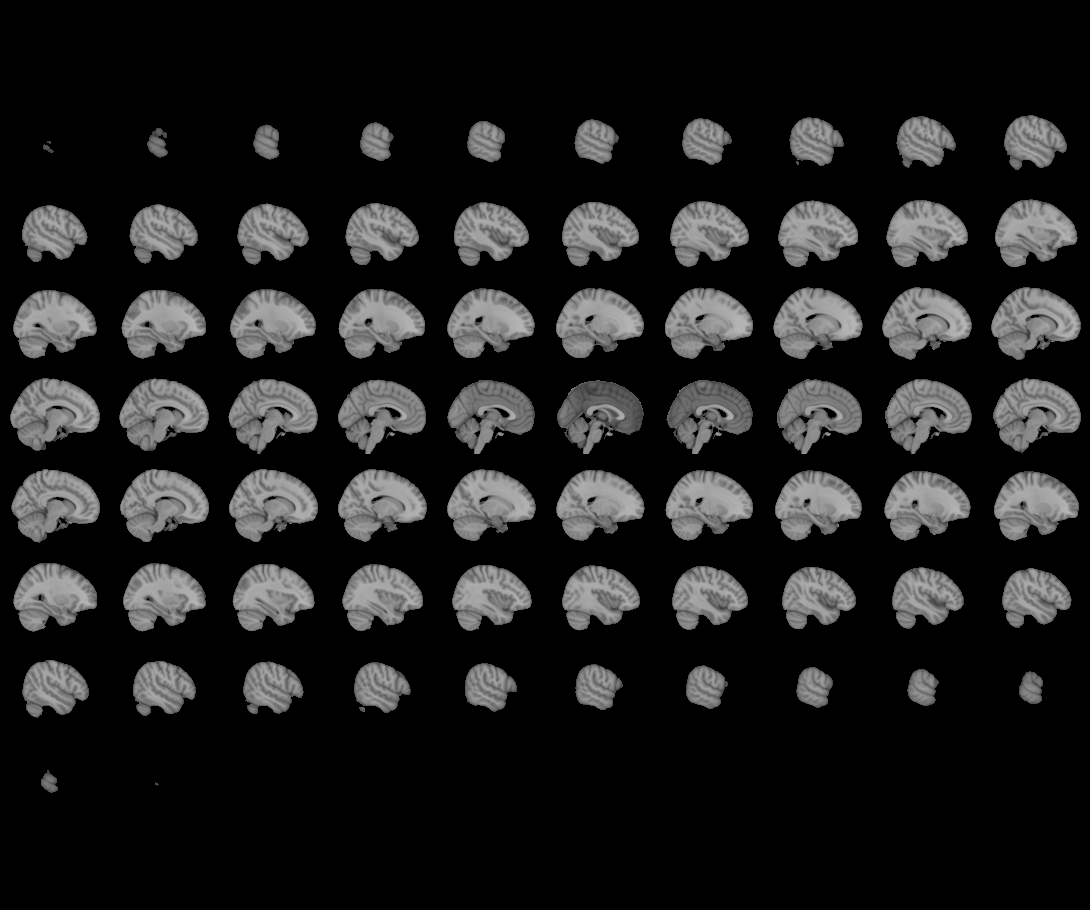
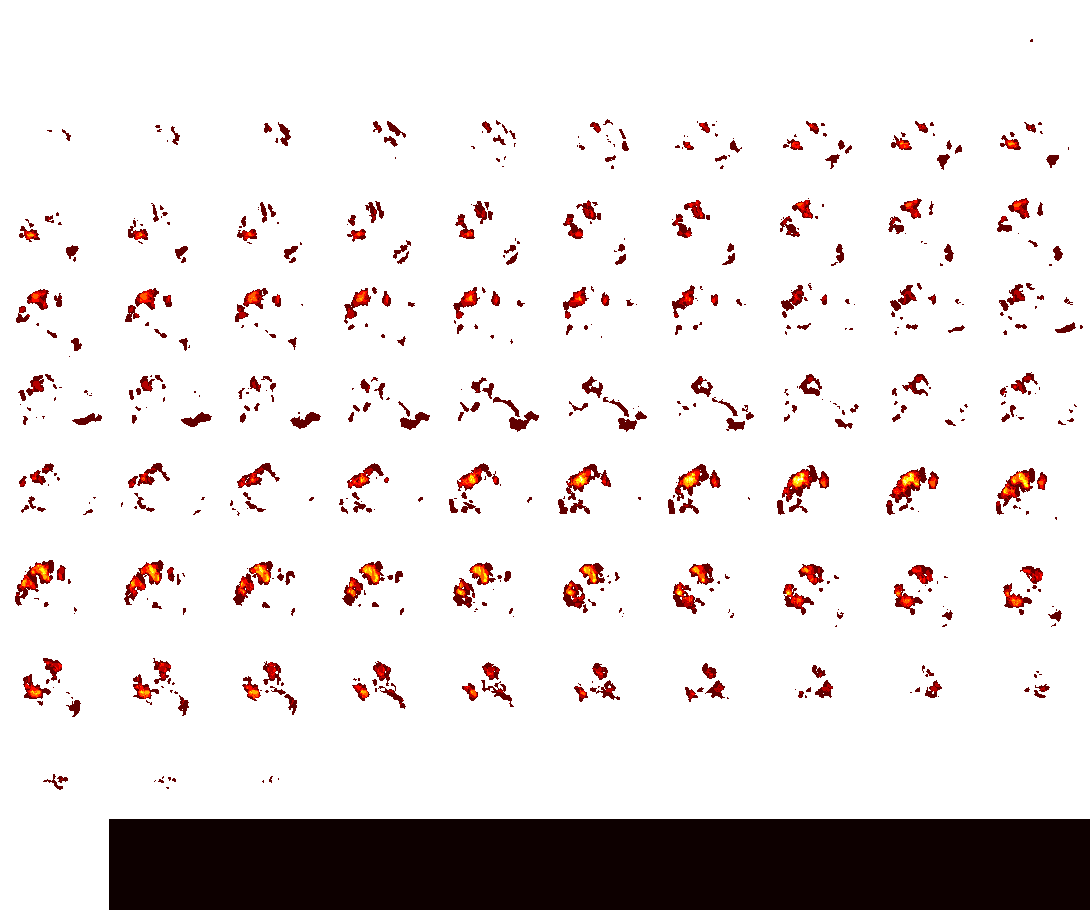

In [32]:
test = nib.Nifti1Image(all_space, affine)  # create the volume image
plotting.view_img(test)

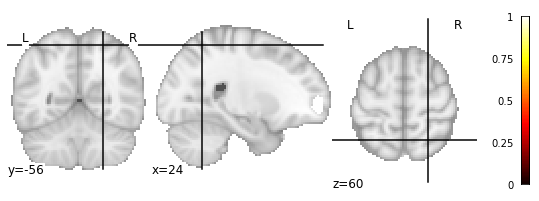

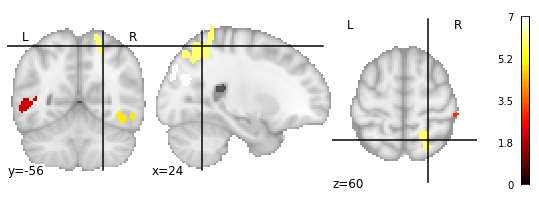

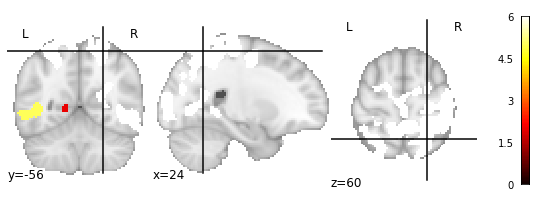

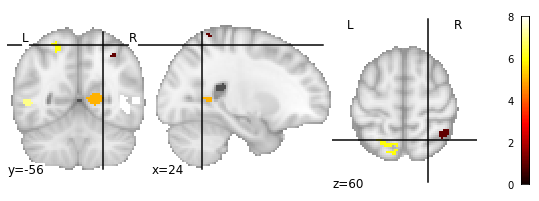

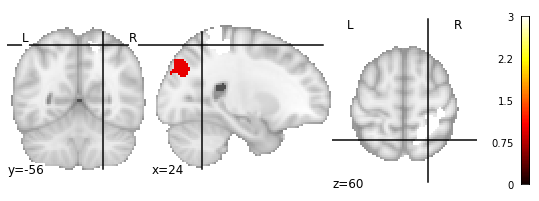

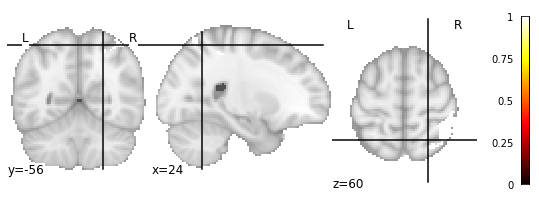

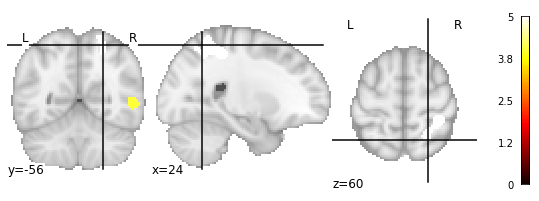

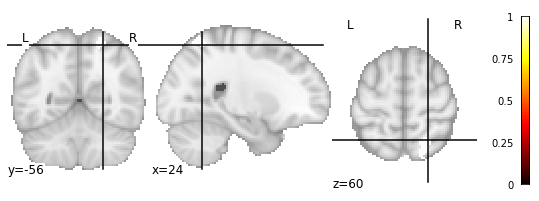

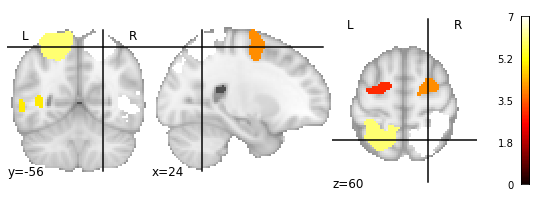

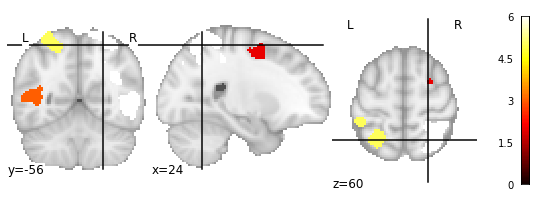

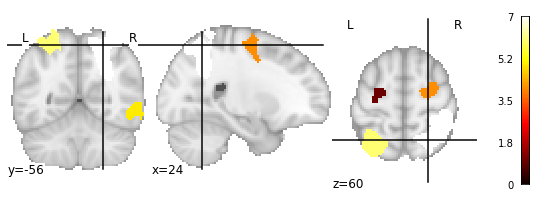

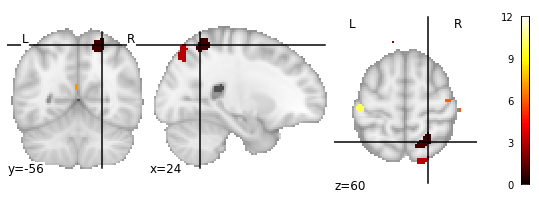

In [46]:
for ss in subs:
    #set sub directory
    sub_dir = f'{study_dir}/sub-{study}{ss}/ses-01/derivatives/fsl'
    #load spaceloc zstatclust
    space_clust = image.load_img(f'{sub_dir}/spaceloc/HighLevel_roi_2runs.gfeat/cope1.feat/cluster_mask_zstat1.nii.gz')

    plotting.plot_stat_map(space_clust, cut_coords=[24, -56, 60])
    plt.pause(0.0001)